# Simplest NN Baseline with Pytorch (for Beginners)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
train = pd.read_csv('Notebooks/icu_data.csv')
# test = pd.read_csv('test.csv')

In [47]:
X = train.drop(['hospital_death'], axis=1)
y = train['hospital_death']
# test = test.drop(columns=['id'])

In [48]:
sc = StandardScaler()
X = sc.fit_transform(X)
# test = sc.transform(test)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [50]:
EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [51]:
class PatientTrain(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class PatientTest(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [52]:
train_data = PatientTrain(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

test_data = PatientTest(torch.FloatTensor(X_test))

In [53]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [54]:
X_train.shape

(35585, 129)

In [55]:
class PatientNet(nn.Module):
    def __init__(self):
        super(PatientNet, self).__init__()
        # Number of input features is 129.
        self.layer_1 = nn.Linear(129, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
       
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
##############

cuda:0


In [57]:
model = PatientNet()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


PatientNet(
  (layer_1): Linear(in_features=129, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [58]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [59]:
losss = []
epoch_losss = []
epoch_accc = []
accs = []
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        losss.append(epoch_loss)
        accs.append(epoch_acc)
    epoch_losss.append(epoch_loss/len(train_loader))
    epoch_accc.append(epoch_acc/len(train_loader))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.23207 | Acc: 91.910
Epoch 002: | Loss: 0.20030 | Acc: 92.722
Epoch 003: | Loss: 0.19388 | Acc: 92.905
Epoch 004: | Loss: 0.18995 | Acc: 92.984
Epoch 005: | Loss: 0.18507 | Acc: 93.115
Epoch 006: | Loss: 0.18086 | Acc: 93.339
Epoch 007: | Loss: 0.17792 | Acc: 93.402
Epoch 008: | Loss: 0.17240 | Acc: 93.607
Epoch 009: | Loss: 0.16683 | Acc: 93.725
Epoch 010: | Loss: 0.16150 | Acc: 93.973
Epoch 011: | Loss: 0.15684 | Acc: 94.176
Epoch 012: | Loss: 0.15110 | Acc: 94.390
Epoch 013: | Loss: 0.14615 | Acc: 94.580
Epoch 014: | Loss: 0.14093 | Acc: 94.738
Epoch 015: | Loss: 0.13631 | Acc: 94.925


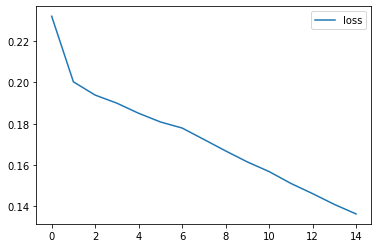

In [60]:
#plot loss and accuracy
plt.plot(epoch_losss, label='loss')
plt.legend()
plt.show()


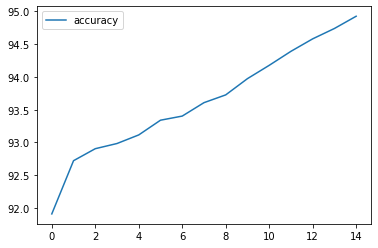

In [61]:
plt.plot(epoch_accc, label='accuracy')
plt.legend()
plt.show()


In [62]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]